# Semi-supervised Graph Node Classification

This notebook goes through the "Cora" dataset example from [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html). 

## Dependencies

Let's load in the dependencies.

In [1]:
import torch
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch_geometric.utils as utils

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tqdm.auto as tqdm
import numpy as np

## About the **Cora** dataset.

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. [Source.](https://paperswithcode.com/dataset/cora)

In [2]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

First, let us see how many different classes the Cora dataset contains.

In [3]:
dataset.num_classes

7

Let's make sure we have 1433 edge features (i.e. which words each article contains.)

In [4]:
dataset.num_node_features

1433

We can also look at the data matrix.

In [5]:
dataset.data.x.shape

torch.Size([2708, 1433])

How many does the training set, validation set and test set contain?

In [6]:
data = dataset[0]
data.train_mask.sum().item(), data.val_mask.sum().item(), data.test_mask.sum().item()

(140, 500, 1000)

# Implementing a Graph Convolutional Networks

Define the GCN.

In [3]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

class RegularizedLoss:
    '''
    Used to calculate the regularized loss.

    Inputs:
        edge_index, edge index of the graph.
        train_mask, train indices that should be used for the training loss.

    '''
    
    def __init__(self, phi, mu, edge_index, train_mask):

        if phi == 'squared_error': 
            self.phi = lambda Zprime, Z : 0.5 * (torch.norm(Zprime - Z, p=2, dim=1) ** 2).sum()
        else:
            raise NotImplementedError()

        #Set the value of mu.
        self.mu = mu

        self.train_mask = train_mask
    
        #Calculate the adjacency matrix.
        A = utils.to_dense_adj(edge_index).squeeze(0)

        #Set N, the number of nodes in the graph.
        self.N, _ = A.shape

        #Calculate the degree matrix, https://github.com/pyg-team/pytorch_geometric/issues/1261#issuecomment-633913984
        D = torch.diag(utils.degree(edge_index[0])) 

        #Here we calculate the Ahat matrix basically two ways depending on whether or not we have isolated nodes.
        if utils.contains_isolated_nodes(edge_index):
            #In the case of isolated nodes, the degree of the node is 0 meaning D is singular. We get around this by replacing inf with 0.
            Dinv = 1./torch.diag(D)
            Dinv[Dinv == float('inf')] = 0
            Dinv = torch.diag(Dinv)
            self.Ahat = torch.matmul(Dinv, A)
        else:
            #If there are no isolated nodes, then all nodes have a degree larger than zero meaning that we can calculate the inverse of D. 
            self.Ahat = torch.linalg.solve(D, A)

        #Use the CrossEntropyLoss. 
        self.cross_entropy = torch.nn.CrossEntropyLoss()

    def __call__(self, Z, y):
        '''
        Evaluate the loss function. 
        '''
        N = len(y)
        
        L1 = self.cross_entropy(Z[self.train_mask], y[self.train_mask])

        Zprime = torch.matmul(self.Ahat, Z)

        #Equation (2) in the paper.
        L2 = self.mu * 1/self.N * self.phi(Zprime, Z)

        return L1 + self.mu * L2

Set the device, model, data and optimizer.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [5]:
def get_masks(A,B,dataset):
    N = dataset.data.num_nodes
    y = dataset.data.y
    C = dataset.num_classes

    _, counts = np.unique(dataset.data.y.numpy(), return_counts=True)

    assert not np.any(counts < (A+B)), f'Not enough examples.'

    train_mask = torch.Tensor([False]).repeat(N) 
    val_mask = torch.Tensor([False]).repeat(N)
    test_mask = torch.Tensor([False]).repeat(N)

    for i in range(C):
        num_in_class = (y == i).sum()
        train_mask[torch.where((y == i))[0][:A]] = True
        val_mask[torch.where((y == i))[0][A:A+B]] = True
        test_mask[torch.where((y == i))[0][A+B:num_in_class]] = True
    return train_mask.bool(), val_mask.bool(), test_mask.bool()

train_mask, val_mask, test_mask = get_masks(100, 5, dataset)

Let's train the model.

In [6]:
#loss_fn = torch.nn.CrossEntropyLoss()
data = dataset[0]
loss_fn = RegularizedLoss(phi = 'squared_error', mu = 0, edge_index = data.edge_index, train_mask = data.train_mask)
model.train()
for epoch in tqdm.tqdm(range(200)):
    optimizer.zero_grad()
    out = model(data)
    
    #loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss = loss_fn(out, data.y)
    
    loss.backward()
    optimizer.step()

100%|██████████| 200/200 [00:09<00:00, 21.41it/s]


Let us also evaluate the model:

In [7]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7880


Let us also plot the confusion matrix.

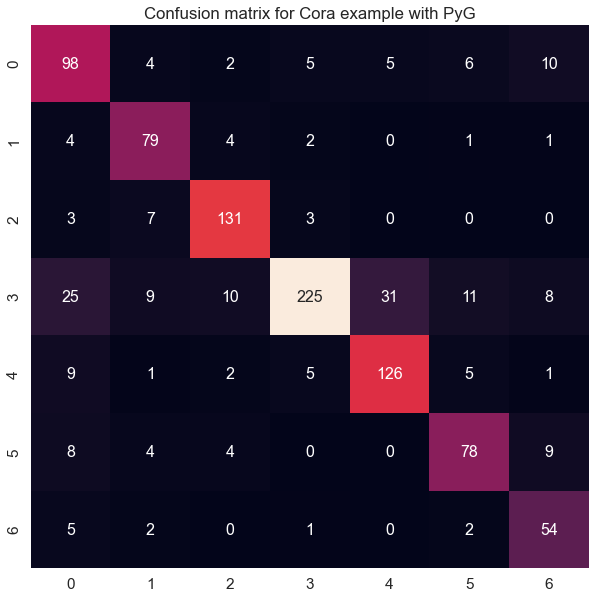

In [8]:
cm = confusion_matrix(y_true = data.y[data.test_mask], y_pred = pred[data.test_mask])
df_cm = pd.DataFrame(cm, range(7), range(7))


plt.figure(figsize=(10,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cbar=False) # font size
plt.title('Confusion matrix for Cora example with PyG')
plt.show()

# Implement A Propagation Function

A propagation function. It should take a network and a high-level embedding and return the propagated embedding. That is, given A and Z in the paper, the function calculated $\hat{​​​​​​​A}​​​​​​​Z$ (recall from my presentation last week, that for each node in the network, the propagated embedding of the node is equal to the average of its neighbors embeddings before the propagation (recall that each row in Z is a node embedding, and $\hat{​​​​​​​A}​​​​​​​Z$ is just a matrix way to write the average embedding over the neighbors of each node).
	For this function, it is a good idea to test it on some small examples. Create a network of five nodes and given them one-dimensional node features. Then test that your implementation gives the correct propagated features.

# Experiments

## Experiment A: Investigate how Accuracy depends on $\mu$

In [48]:
import time
import pickle
import datetime

# -- Set experiment parameters -- #
mu_range = np.linspace(0, 1, 5)
n_sim    = 3
n_epoch  = 200
acc = {}

#Datasets that we want to loop over.
datasets = ['Cora', 'CiteSeer', 'PubMed']

#Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for dataset_str in datasets:
    #Load in the dataset.
    dataset = Planetoid(root=f'/tmp/{dataset_str}', name=dataset_str)

    acc_matrix = np.zeros((n_sim, len(mu_range))) #nsim x mu_range

    for i in range(n_sim):
        for j, mu in tqdm.tqdm(enumerate(mu_range), desc=f'Training GCN on {dataset_str} for all values of mu: {i+1}/{n_sim}', total=len(mu_range)):

            #Set model, data and optimizer.
            model = GCN().to(device)
            data = dataset[0].to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

            #Define the loss.
            loss_fn = RegularizedLoss(phi = 'squared_error', mu = mu, edge_index = data.edge_index, train_mask = data.train_mask)
            
            #Train loop
            model.train()
            for epoch in range(n_epoch):
                optimizer.zero_grad()
                out = model(data)
                loss = loss_fn(out, data.y)
                loss.backward()
                optimizer.step()

            #Evaluate the performance
            model.eval()
            pred = model(data).argmax(dim=1)
            correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
            
            #Save it to acc_matrix. 
            acc_matrix[i,j] = int(correct) / int(data.test_mask.sum())

    #Save the acc matrix for this dataset.
    acc[dataset_str] = acc_matrix

#Dump the results in a pickle file!
now = datetime.datetime.now()
filename = f'ExperimentA_{now.strftime("%Y_%m_%d_%H_%M")}.pickle'

with open(filename, 'wb') as handle:
    pickle.dump([mu_range, acc, datasets], handle)

Training GCN on Cora for all values of mu: 2/3:  40%|████      | 2/5 [00:26<00:40, 13.47s/it]


KeyboardInterrupt: 

Plot the results.

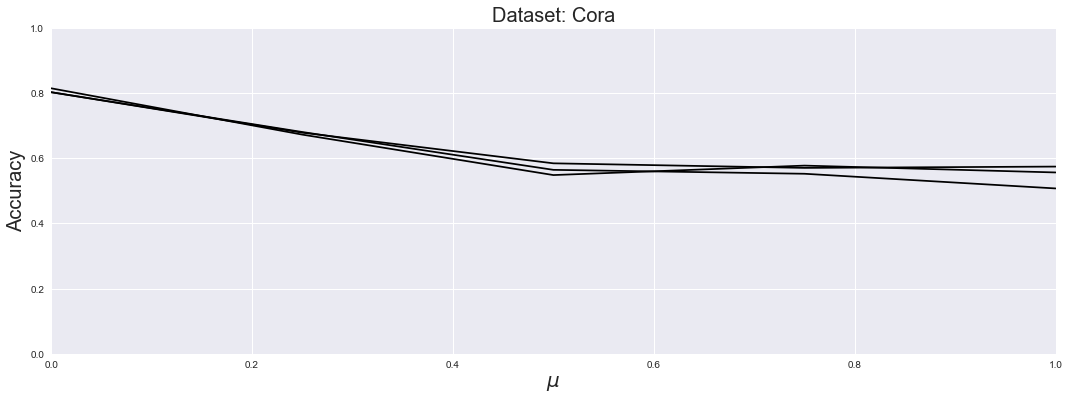

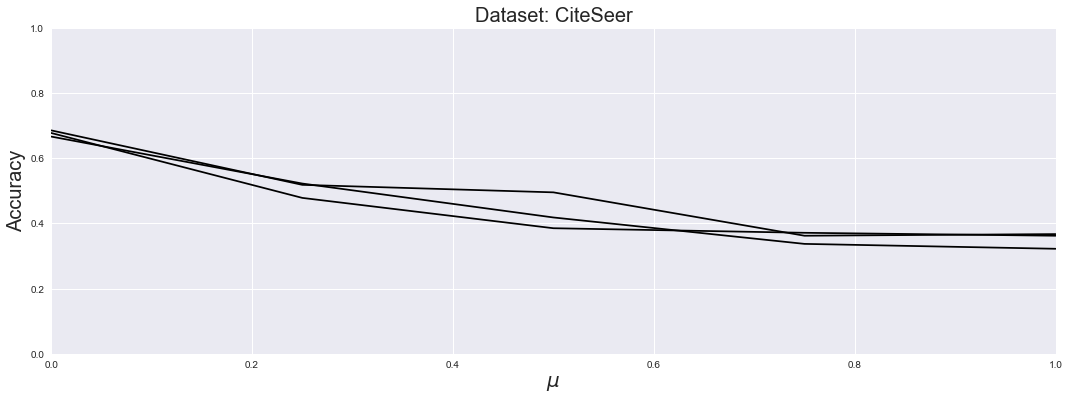

In [47]:
filename = '2022_03_10_09_10.pickle'

with open(filename, 'rb') as handle:
    mu_range, acc, datasets = pickle.load(handle)

plt.style.use('seaborn')
for dataset in datasets:
    plt.figure(figsize=(18, 6))
    for sim in acc[dataset]:
        plt.plot(mu_range, sim, 'k')
    plt.xlim(0, 1)
    plt.title(f'Dataset: {dataset}', fontsize=20)
    plt.ylim(0, 1)
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('$\mu$', fontsize=20)
    plt.show()

# Experiment 2: Calculate accuracy, ROC-AUC and RMSE of the GCN with and without P-reg using ten random 20/30/rest splits.

In [68]:
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score

In [58]:
import time
import pickle
import datetime

# -- Set experiment parameters -- #
mu_range = np.linspace(0, 1, 5)
n_sim    = 3
n_epoch  = 200
acc = {}

#Datasets that we want to loop over.
datasets = ['Cora', 'CiteSeer', 'PubMed']

#Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for dataset_str in datasets:
    #Load in the dataset.
    dataset = Planetoid(root=f'/tmp/{dataset_str}', name=dataset_str)

    #Fetch the 20/30/rest masks.
    train_mask, _, test_mask = get_masks(20, 30, dataset)

    #Set model, data and optimizer.
    model = GCN().to(device)
    data = dataset[0].to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    #Define the loss.
    loss_fn = RegularizedLoss(phi = 'squared_error', mu = mu, edge_index = data.edge_index, train_mask = train_mask)    

    #Train loop
    model.train()
    for epoch in range(n_epoch):
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()

    #Evaluate the performance
    model.eval()
    pred = model(data).argmax(dim=1)
    score = torch.softmax(model(data), dim=1)

    #How to calculate the RMSE: https://stackoverflow.com/a/18623635/17389949
    train_rms = mean_squared_error(y_true = data.y[train_mask], y_pred = pred[train_mask])
    train_roc_auc_score = roc_auc_score(y_true = data.y[train_mask], y_score = score[train_mask, :])
    train_acc = accuracy_score(y_true = data.y[train_mask], y_pred = pred[train_mask])

    #Let's do the same for the test data.
    test_rms = mean_squared_error(y_true = data.y[test_mask], y_pred = pred[test_mask])
    test_roc_auc_score = roc_auc_score(y_true = data.y[test_mask], y_score = score[test_mask, :])
    test_acc = accuracy_score(y_true = data.y[test_mask], y_pred = pred[test_mask])

    #TODO: Save the parameters to W&B or something.

# Experiment C - Investigate how the accuracy is affected by increasing the number of nodes in the training set with and without P-reg.

Basically the same as above, only we change the input to the `get_splits` function.

# Visualize Network Embeddings

In [71]:
model(data)

tensor([[-0.4399, -0.8053, -0.6771,  ..., -1.2050, -0.9453, -0.8723],
        [-1.0248, -0.9117, -0.5876,  ...,  5.5520, -0.7763, -0.6808],
        [-0.7046, -0.8643, -0.4400,  ...,  4.2044, -0.6490, -0.8148],
        ...,
        [ 0.1728,  0.2005, -0.3606,  ...,  0.0388,  0.2351, -0.3609],
        [-0.2117, -0.1617,  0.2032,  ...,  0.3519, -0.0220, -0.7860],
        [-0.2494, -0.1543,  0.1763,  ...,  0.2672, -0.0982, -0.7999]],
       grad_fn=<AddBackward0>)

In [73]:
data.y.unique().shape

torch.Size([7])

In [26]:
from bhtsne import tsne

In [30]:
model = GCN()

In [31]:
X = model(data).detach().numpy().astype('float64')
Y = tsne(X)

Using current time as random seed...
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 0 of 2708
Input similarities computed in 0.30 seconds (sparsity = 0.049642)!
Learning embedding...
Iteration 50: error is 81.346444 (50 iterations in 0.94 seconds)
Iteration 100: error is 78.674143 (50 iterations in 1.13 seconds)
Iteration 150: error is 78.253357 (50 iterations in 0.96 seconds)
Iteration 200: error is 78.175671 (50 iterations in 0.95 seconds)
Iteration 250: error is 4.029700 (50 iterations in 0.90 seconds)
Iteration 300: error is 2.168507 (50 iterations in 0.83 seconds)
Iteration 350: error is 1.894164 (50 iterations in 0.93 seconds)
Iteration 400: error is 1.767102 (50 iterations in 0.96 seconds)
Iteration 450: error is 1.699117 (50 iterations in 0.93 seconds)
Iteration 500: error is 1.660094 (50 iterations in 0.93 seconds)
Iteration 550: error is 1.638490 (50 iterations in 0.97 seconds)
Iteration 600: error is 

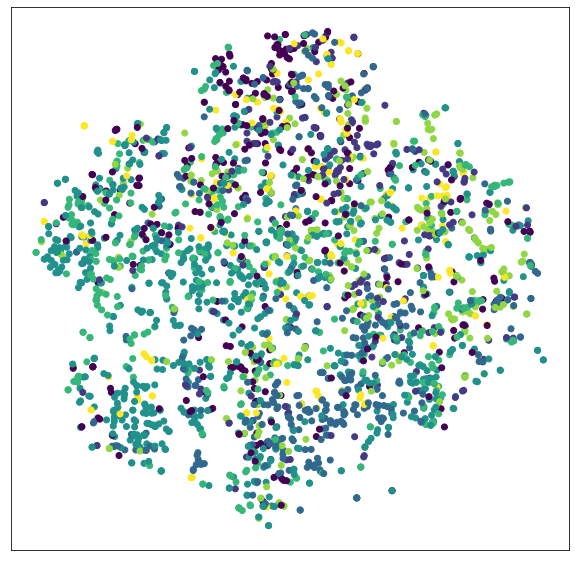

In [32]:
plt.figure(figsize=(10,10))
plt.scatter(Y[:, 0], Y[:, 1], c = data.y)
plt.xticks([])
plt.yticks([])
plt.show()